# Stage 2 - Transportation & Mobility

## Importation des modules

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd
import contextily as cx

import gtfs_functions as gtfs
#from gtfslite.gtfs import GTFS
import gtfsutils
import gtfsutils.routes
import gtfsutils.filter

import folium
import geojson
import json
import datetime

#os.chdir("/Users/romanelgff/Documents/Master/WDL/stage2")
os.getcwd()

'C:\\Users\\heloi\\WDL - Stage 2 - Transportation & Mobility'

## Exploring E-Scooter OD Data

In [4]:
df1 = pd.read_csv("Soft-Mobility/E-Scooter OD/wdl_od_view.csv")

In [5]:
df1.head()

,recorded,id,device_id,timestamp,event_types,vehicle_state,trip_state,telemetry_timestamp,trip_id,lat,lng
0,1634809115769,1,a7990baa-909e-42ed-8546-a2a9d2e42b3c,1634734083000,{trip_leave_jurisdiction},elsewhere,NaN,1634734079000,6e073f7f-b955-4033-b7bd-6237faa51507,41.147263,-8.674807
1,1635342117495,1223,abf136d8-a3d4-4d5f-92bf-70f5986fc5cb,1635342117000,{maintenance_pick_up},removed,NaN,1635342113000,NaN,41.168862,-8.671213
2,1635282790287,3,a0623c68-106a-4275-a059-0f10645d7367,1635282790000,{trip_start},on_trip,NaN,1635282555000,cfc0bda1-067d-4470-881c-a6de48cd0d61,41.148018,-8.665110
3,1635342119299,1224,035ba91e-6e01-475f-8ec7-ba0933feb6a1,1635342119000,{maintenance_pick_up},removed,NaN,1635342115000,NaN,41.168777,-8.671162
4,1635282792989,5,438f37e9-53cd-450c-9110-5528b1ab0871,1635282728000,{trip_start},on_trip,NaN,1635282475000,c62fe7e8-be9b-4380-8565-c1932bb3322a,41.145118,-8.612310


## Exploring E-Scooter Parks Data

In [6]:
f = open("Soft-Mobility/E-Scooter Parks/e-scooter_parks.json") # E-Scooter Parks Location Data
df2 = json.load(f)
print(json.dumps(df2, indent=4, sort_keys=True))

{
    "displayFieldName": "toponimo",
    "features": [
        {
            "attributes": {
                "estado": "ATIVO",
                "n_id": 204,
                "n_lugares": 10,
                "objectid_1": 199,
                "sinal_info_vert": "SIM",
                "sinal_vert": "NAO",
                "toponimo": "Rua de D. Pedro V"
            },
            "geometry": {
                "x": -8.630972406820455,
                "y": 41.149252223614546
            }
        },
        {
            "attributes": {
                "estado": "ATIVO",
                "n_id": 35,
                "n_lugares": 10,
                "objectid_1": 32,
                "sinal_info_vert": "SIM",
                "sinal_vert": "NAO",
                "toponimo": "Rua de D. Pedro V"
            },
            "geometry": {
                "x": -8.6324746693067,
                "y": 41.14749908119241
            }
        },
        {
            "attributes": {
                "estado

In [7]:
df = pd.DataFrame()
columns = ['x','y']
data = []

for f in df2["features"]:
  s = f['geometry']
  values = [s['x'], s['y']]
  zipped = zip(columns, values)
  a_dictionary = dict(zipped)
  data.append(a_dictionary)

df = df.append(data, True)

print(df) # dateframe of coordinates

            x          y
0   -8.630972  41.149252
1   -8.632475  41.147499
2   -8.667407  41.147554
3   -8.670062  41.148510
4   -8.671516  41.148982
..        ...        ...
211 -8.636103  41.165483
212 -8.657355  41.170204
213 -8.637309  41.173360
214 -8.659702  41.167479
215 -8.653902  41.173706

[216 rows x 2 columns]


In [8]:
geoms = gpd.points_from_xy(df['x'], df['y'])
names = []
for f in df2['features']:
    names.append(f['attributes']['estado'])

gdf = gpd.GeoDataFrame({'name': names}, geometry=geoms, crs=4326)
#gdf.crs = {'init': 'epsg:4326'}
#gdf_proj = gdf.to_crs({'init': 'epsg:3857'})

gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
parks = folium.Map([41.1579, -8.6291],
                  zoom_start=13,
                  tiles='cartodbpositron')

points = folium.features.GeoJson(gdf)

parks.add_child(points)
parks

## GTFS Files (common format for public transportation schedules and associated geographic information)

## Process gtfs_bus.zip file
Source : https://max-coding.medium.com/how-to-process-gtfs-data-using-pandas-geopandas-4b34f2ad3273

In [183]:
gtfs_bus = GTFS.load_zip("Soft-Mobility/GTFS/gtfs_bus.zip")
print(gtfs_bus.summary()) # first date : 2020-06-06, last date : 2021-96-13 (~ 1 year)

['agency.txt', 'stops.txt', 'routes.txt', 'trips.txt', 'stop_times.txt', 'calendar.txt', 'calendar_dates.txt', 'fare_attributes.txt', 'fare_rules.txt', 'shapes.txt', 'frequencies.txt', 'transfers.txt', 'pathways.txt', 'levels.txt', 'translations.txt', 'feed_info.txt', 'attributions.txt']
agencies               [Metro do Porto]
total_stops                          84
total_routes                          8
total_trips                        1117
total_stops_made                  27070
first_date          2021-09-10 00:00:00
last_date           2022-09-14 00:00:00
total_shapes                        144
dtype: object


In [167]:
from zipfile import ZipFile
with ZipFile("Soft-Mobility/GTFS/gtfs_bus.zip") as myzip:
    
    shapes_df = pd.read_csv(myzip.open("shapes.txt"), dtype={
        'shape_id': 'str', 
        'shape_pt_lat': 'float', 
        'shape_pt_lon': 'float',  
        'shape_pt_sequence': 'Int64', 
        'shape_dist_traveled': 'float',
    })
    
    routes_df = pd.read_csv(myzip.open("routes.txt"), dtype={
        'route_id': 'str',  
        'agency_id': 'str',  
        'route_short_name': 'str',  
        'route_long_name': 'str', 
        'route_desc': 'str', 
        'route_type': 'Int64',
        'route_color': 'str',  
        'route_text_color': 'str', 
        'exact_times': 'bool'
    })
    
    trips_df = pd.read_csv(myzip.open("trips.txt"), dtype={
        'route_id': 'str', 
        'service_id': 'str',  
        'trip_id': 'str',
        'shape_id': 'str', 
        'trip_headsign': 'str', 
        'direction_id': 'str',  
        'block_id': 'str', 
        'wheelchair_accessible': 'str', 
        'route_direction': 'str', 
        'trip_note': 'str', 
        'bikes_allowed': 'str'
    })
    
    calendar_df = pd.read_csv(myzip.open("calendar.txt"), dtype={
        'service_id': 'str',  
        'monday': 'bool',  
        'tuesday': 'bool',  
        'wednesday': 'bool',  
        'thursday': 'bool',  
        'friday': 'bool', 
        'saturday': 'bool',  
        'sunday': 'bool',  
        'start_date': 'str', 
        'end_date': 'str',
    })
    
    calendar_dates_df = pd.read_csv(myzip.open("calendar_dates.txt"), dtype={
        'service_id': 'str',  
        'date': 'str',
        'exception_type': 'Int64',
    })

In [168]:
shapes_gdf = gpd.GeoDataFrame(shapes_df, 
        geometry=gpd.points_from_xy(shapes_df.shape_pt_lon, shapes_df.shape_pt_lat)).set_crs(epsg=4326)
shapes_gdf

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,geometry
0,505_1_1_shp,41.184602,-8.608740,426,POINT (-8.60874 41.18460)
1,505_1_1_shp,41.184635,-8.608341,427,POINT (-8.60834 41.18464)
2,505_1_1_shp,41.184625,-8.607833,428,POINT (-8.60783 41.18462)
3,505_1_1_shp,41.184597,-8.607355,429,POINT (-8.60736 41.18460)
4,505_1_1_shp,41.184510,-8.606877,430,POINT (-8.60688 41.18451)
...,...,...,...,...,...
36709,505_1_1_shp,41.183308,-8.612480,421,POINT (-8.61248 41.18331)
36710,505_1_1_shp,41.184203,-8.610260,422,POINT (-8.61026 41.18420)
36711,505_1_1_shp,41.184401,-8.609694,423,POINT (-8.60969 41.18440)
36712,505_1_1_shp,41.184534,-8.609154,424,POINT (-8.60915 41.18453)


In [169]:
calendar_df # columns monday-sunday contain True if service is running on that week day

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UTEISFE,True,True,True,True,True,False,False,20210322,20210404
1,SABFE,False,False,False,False,False,True,False,20210322,20210404
2,DOMFE,False,False,False,False,False,False,True,20210322,20210404
3,UTEIS,True,True,True,True,True,False,False,20210405,20210613
4,SAB,False,False,False,False,False,True,False,20210405,20210613
5,DOM,False,False,False,False,False,False,True,20210405,20210613
6,UTEISAGOST,True,True,True,True,True,False,False,20200803,20200913
7,SABAGOST,False,False,False,False,False,True,False,20200803,20200913
8,DOMAGOST,False,False,False,False,False,False,True,20200803,20200913
9,ELECUTEIS,True,True,True,True,True,False,False,20200606,20210613


In [181]:
calendar_dates_df[calendar_dates_df.date == '20200815'] # service with ID SABAGOST was cancelled on 15 August 2020

,service_id,date,exception_type
14,SABAGOST,20200815,2
15,DOMAGOST,20200815,1


### Focus date: 15 August 2020

In [171]:
show_date_str = "2020-08-15"
date = datetime.datetime.strptime(show_date_str, "%Y-%m-%d")
date_string = date.strftime("%Y%m%d")
day_of_week_name = date.strftime('%A').lower()

print(date)
print(date_string)
print(day_of_week_name)

2020-08-15 00:00:00
20200815
saturday


In [175]:
services_for_day_1 = calendar_df[(calendar_df[day_of_week_name])
                & (date_string >= calendar_df.start_date)
                & (date_string <= calendar_df.end_date)].service_id.to_numpy()
print(f"scheduled for day based on calendar: {len(services_for_day_1)}")

scheduled for day based on calendar: 2


In [176]:
services_added_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 1)].service_id.to_numpy()
services_removed_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 2)].service_id.to_numpy()

print(f"Services added using calendar dates : {len(services_added_for_day)}")
print(f"Services removed using calendar dates : {len(services_removed_for_day)}")

Services added using calendar dates : 1
Services removed using calendar dates : 1


In [177]:
services_for_day_2 = np.concatenate([services_for_day_1, services_added_for_day])
services_for_day = np.setdiff1d(services_for_day_2, services_removed_for_day)

In [179]:
services_for_day

array(['DOMAGOST', 'ELECSAB'], dtype=object)

### Get each route segment with start and end coordinates and sequence along the shape

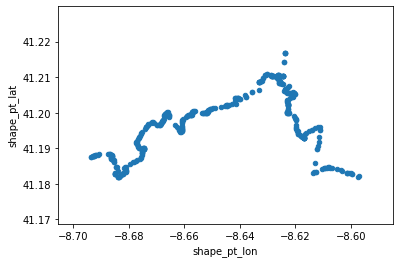

In [186]:
# plotting route points for shape ID 505_1_1_shp (the only one ??)
shapes_df[shapes_df.shape_id == "505_1_1_shp"].plot.scatter(x="shape_pt_lon", y="shape_pt_lat")

In [185]:
# converting sequence of points into set of straight lines
coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
coords_roll_1 = np.roll(coords, 1, axis=0)

segments = pd.DataFrame(np.concatenate([coords_roll_1, coords], axis=1), columns=["start_lat", "start_lng", "start_seq", "end_lat", "end_lng", "end_seq"])

segments_df = shapes_df[["shape_id"]].join(segments)
segments_df = segments_df[segments_df.end_seq != 1]
segments_df = segments_df.drop(columns=['end_seq']).rename(columns={ "start_seq": "seq" })
segments_df # each row contains segment start and end point

,shape_id,start_lat,start_lng,seq,end_lat,end_lng
0,505_1_1_shp,41.184534,-8.609154,425,41.184602,-8.60874
1,505_1_1_shp,41.184602,-8.60874,426,41.184635,-8.608341
2,505_1_1_shp,41.184635,-8.608341,427,41.184625,-8.607833
3,505_1_1_shp,41.184625,-8.607833,428,41.184597,-8.607355
4,505_1_1_shp,41.184597,-8.607355,429,41.18451,-8.606877
...,...,...,...,...,...,...
36709,505_1_1_shp,41.183244,-8.612713,420,41.183308,-8.61248
36710,505_1_1_shp,41.183308,-8.61248,421,41.184203,-8.61026
36711,505_1_1_shp,41.184203,-8.61026,422,41.184401,-8.609694
36712,505_1_1_shp,41.184401,-8.609694,423,41.184534,-8.609154


### Get number of trips for each shape

In [184]:
day_trips = trips_df[trips_df.service_id.isin(services_for_day)]
shape_day_trips = day_trips.groupby(by="shape_id").size().to_frame("day_trips")
shape_day_trips

,day_trips
shape_id,
18_0_1_shp,24
1_0_1_shp,33
1_1_1_shp,33
22_0_1_shp,21


### Merge segments with day trip counts

In [153]:
shape_segments_day_trips = pd.merge(segments_df, shape_day_trips, left_on="shape_id", right_index=True)

# how many trip occurs in each segment per day
shape_segments_day_trips = pd.merge(segments_df, shape_day_trips, left_on="shape_id", right_index=True)

segment_day_trips = shape_segments_day_trips.groupby(by=[
    "start_lat", "start_lng", "end_lat", "end_lng"]).sum("day_trips").reset_index()

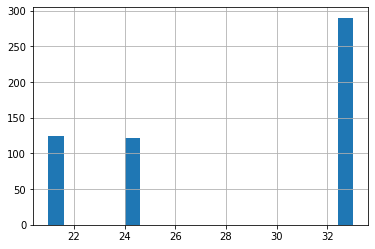

In [154]:
segment_day_trips.day_trips.hist(bins=20)

### Create LineString geometry for segment and create GeoDataFrame

In [155]:
from shapely.geometry import Point, LineString

def get_line_string(row):
    start = Point(row.start_lng, row.start_lat)
    end = Point(row.end_lng, row.end_lat)
    line = LineString([start, end])
    row["geometry"] = line
    return row

segment_day_trips_gpd = gpd.GeoDataFrame(segment_day_trips.apply(get_line_string, axis=1)).set_crs(epsg=4326)
segment_day_trips_gpd

,start_lat,start_lng,end_lat,end_lng,day_trips,geometry
0,41.140558,-8.616319,41.140561,-8.616416,33.0,"LINESTRING (-8.61632 41.14056, -8.61642 41.14056)"
1,41.140561,-8.616416,41.140587,-8.616516,33.0,"LINESTRING (-8.61642 41.14056, -8.61652 41.14059)"
2,41.140568,-8.616204,41.140558,-8.616319,33.0,"LINESTRING (-8.61620 41.14057, -8.61632 41.14056)"
3,41.140587,-8.616516,41.140644,-8.616657,33.0,"LINESTRING (-8.61652 41.14059, -8.61666 41.14064)"
4,41.140588,-8.616105,41.140568,-8.616204,33.0,"LINESTRING (-8.61610 41.14059, -8.61620 41.14057)"
...,...,...,...,...,...,...
531,41.148539,-8.647562,41.148539,-8.647175,33.0,"LINESTRING (-8.64756 41.14854, -8.64718 41.14854)"
532,41.148539,-8.647175,41.148536,-8.646611,33.0,"LINESTRING (-8.64718 41.14854, -8.64661 41.14854)"
533,41.148539,-8.647169,41.148497,-8.647515,33.0,"LINESTRING (-8.64717 41.14854, -8.64752 41.14850)"
534,41.148540,-8.646759,41.148539,-8.647169,33.0,"LINESTRING (-8.64676 41.14854, -8.64717 41.14854)"


### Plot each segment with color showing number of trips per day

Text(0.5, 1, 'Number of trips per day on Porto Scooters Network on 14 August 2020')

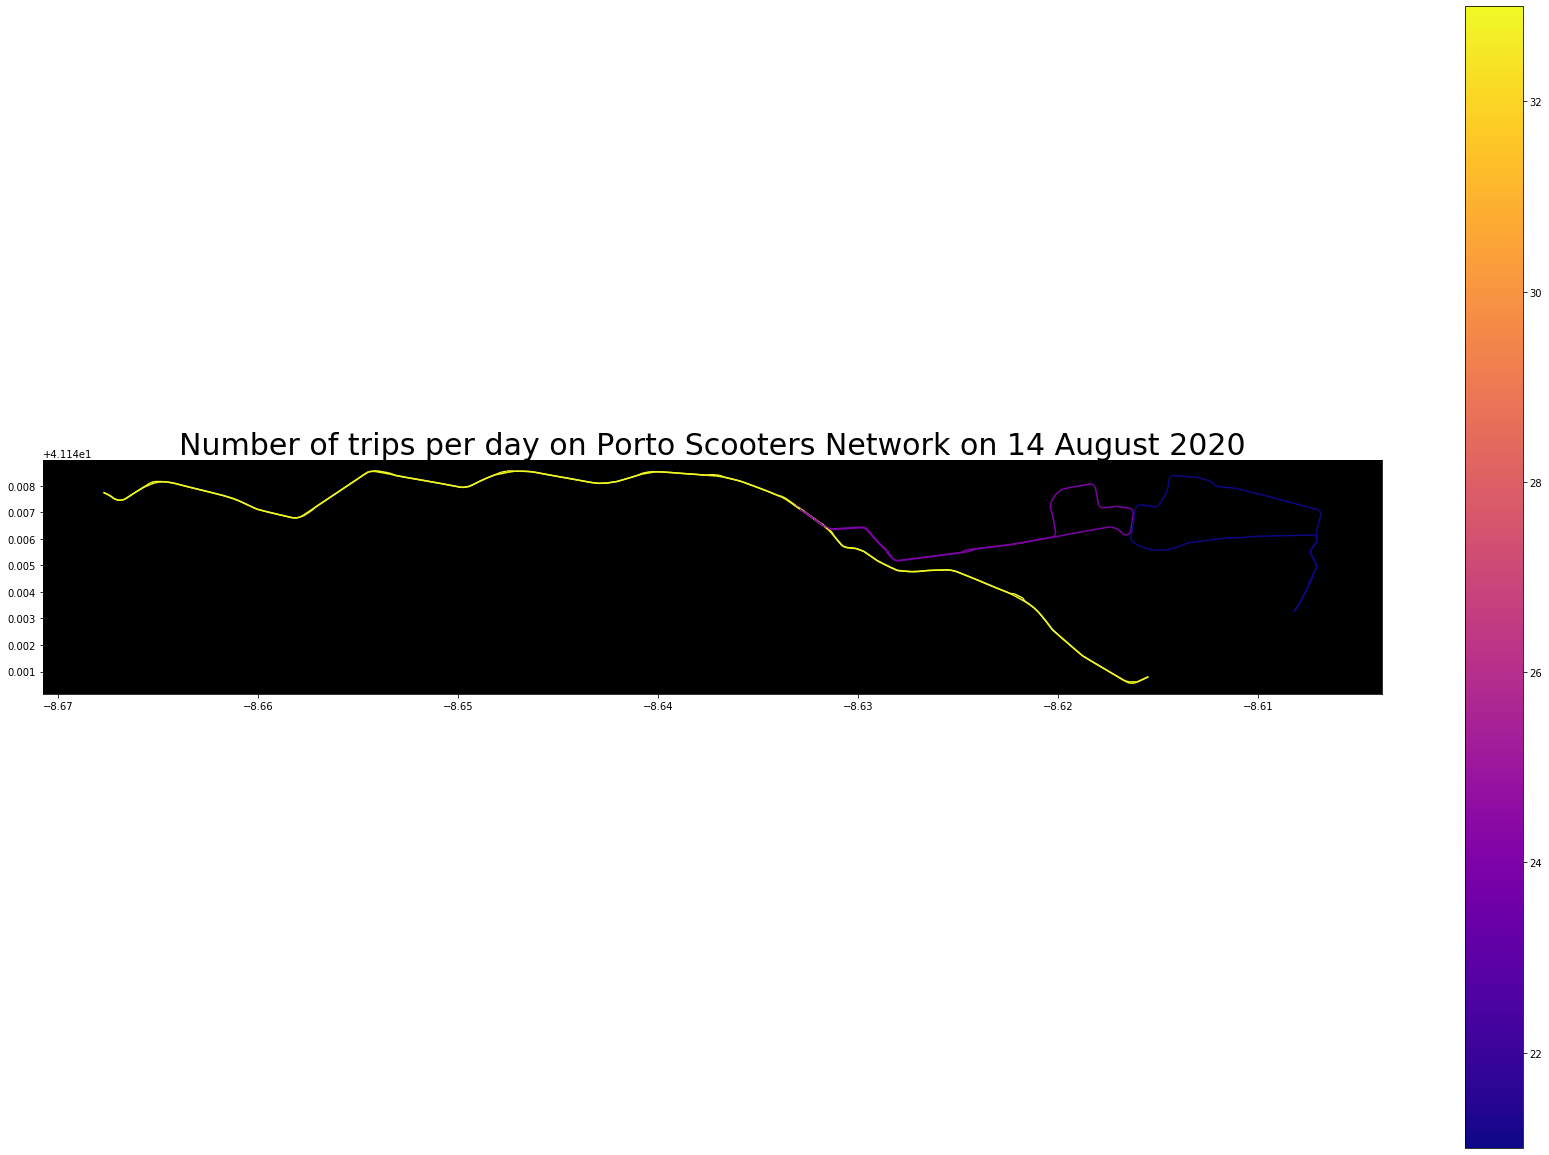

In [156]:
import matplotlib.colors as mcolors

vmin = segment_day_trips_gpd["day_trips"].min()
vmax = segment_day_trips_gpd["day_trips"].quantile(.95)
vcenter = segment_day_trips_gpd["day_trips"].mean()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")

def limit_to_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]

segment_day_trips_gpd.plot(ax=ax, cmap="plasma", column='day_trips', legend=True, norm=norm)

ax.set_title(f"Number of trips per day on Porto Scooters Network on {date:%d %B %Y}", fontsize=30)


### GTFS_Metro

In [31]:
gtfs_metro = GTFS.load_zip("Soft-Mobility/GTFS/gtfs_metro.zip")

['agency.txt', 'stops.txt', 'routes.txt', 'trips.txt', 'stop_times.txt', 'calendar.txt', 'calendar_dates.txt', 'fare_attributes.txt', 'fare_rules.txt', 'shapes.txt', 'frequencies.txt', 'transfers.txt', 'pathways.txt', 'levels.txt', 'translations.txt', 'feed_info.txt', 'attributions.txt']


In [32]:
gtfs_metro.agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,NaN,Metro do Porto,http://www.metrodoporto.pt,Europe/Lisbon,pt


In [33]:
gtfs_metro.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url
0,1,NaN,Estadio do Dragao,NaN,41.160716,-8.582416,PRT1,NaN
1,2,NaN,Campanha,NaN,41.150537,-8.586245,PRT1,NaN
2,3,NaN,Heroismo,NaN,41.146697,-8.592978,PRT1,NaN
3,4,NaN,24 de Agosto,NaN,41.148796,-8.598349,PRT1,NaN
4,5,NaN,Bolhao,NaN,41.149785,-8.605901,PRT1,NaN


In [34]:
gtfs_metro.routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,A,NaN,A,Linha Azul,NaN,1,NaN,00ADEF,NaN
1,B,NaN,B,Linha Vermelha,NaN,1,NaN,EF412F,NaN
2,Bex,NaN,B Expresso,Linha Vermelha Expresso,NaN,1,NaN,EF412F,NaN
3,C,NaN,C,Linha Verde,NaN,1,NaN,8DC63F,NaN
4,D,NaN,D,Linha Amarela,NaN,1,NaN,FFC20E,NaN


## TEST
https://stanmart.github.io/geodata/datashader/python/plotting/budapest/2018/10/17/bkk-datashader/

In [78]:
trips = pd.read_csv('Soft-Mobility/GTFS/gtfs_metro/trips.txt', low_memory=False)
shapes = pd.read_csv('Soft-Mobility/GTFS/gtfs_metro/shapes.txt', low_memory=False)

In [79]:
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,D,DU,DU0,IPO,0,NaN,D
1,D,DU,DU1,Santo Ovidio,1,NaN,D
2,D,DS,DS0,IPO,0,NaN,D
3,D,DS,DS1,Santo Ovidio,1,NaN,D
4,D,DDF,DDF0,IPO,0,NaN,D


In [80]:
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,A,41.160716,-8.582416,0,NaN
1,A,41.150537,-8.586245,1,NaN
2,A,41.146697,-8.592978,2,NaN
3,A,41.148796,-8.598349,3,NaN
4,A,41.149785,-8.605901,4,NaN


In [81]:
num_trips_by_shape = trips.groupby('shape_id').aggregate({'route_id': 'count'}).reset_index()
num_trips_by_shape.rename({'route_id': 'trip_count'}, axis='columns', inplace=True)

shapes_with_nums = shapes.merge(num_trips_by_shape, on='shape_id')
shapes_with_nums.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,trip_count
0,A,41.160716,-8.582416,0,NaN,6
1,A,41.150537,-8.586245,1,NaN,6
2,A,41.146697,-8.592978,2,NaN,6
3,A,41.148796,-8.598349,3,NaN,6
4,A,41.149785,-8.605901,4,NaN,6
